## Домашнее задание по теме "Поиск выбросов и генерация новых признаков"

***Задачи:***   
    1. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
    2. Построить случайный лес, вывести важность признаков  
    3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную и 1 нелинейную модель
    4. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
    5. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

***План работы:***  
    1. Изучить и предобработать данные    
    2. Обучить модель случайного леса, вывести важность признаков, использовать 10-fold кросс-валидацию для оценки качества   
    3. Обучить стекинг минимум из 3х моделей. Для валидации модели 2-го уровня использовать hold-out датасет  
    4. Написать выводы

### Шаг 1. Изучение и предобработка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from jupyterthemes import jtplot
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn import svm
%matplotlib inline
jtplot.style()

In [3]:
houses = pd.read_csv('train.csv')
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Итак, у нас датасет из 1460 строк и 81 колонки. Не все колонки заполнены на 100%. Чтобы было проще увидеть, какие колонки имеют пропуски, выведем их:

In [5]:
empty_df = pd.DataFrame()
column = []
empty_values = []
type_column = []
for i in houses.columns:
    if houses[i].isna().sum() < 1:
        continue
    else:
        column.append(i)
        empty_values.append(houses[i].isna().sum())
        type_column.append(houses[i].dtypes)
        print('Столбец: ', '\x1b[1;0346m'+'{} '.format(i) +'\x1b[0m', 'всего пропусков: ', '\x1b[1;0346m'+'{}'.format(houses[i].isna().sum()) +'\x1b[0m')
empty_df['Столбец'] = column
empty_df['Пропущено значений'] = empty_values
empty_df['Тип данных'] = type_column

Столбец:  LotFrontage  всего пропусков:  259
Столбец:  Alley  всего пропусков:  1369
Столбец:  MasVnrType  всего пропусков:  8
Столбец:  MasVnrArea  всего пропусков:  8
Столбец:  BsmtQual  всего пропусков:  37
Столбец:  BsmtCond  всего пропусков:  37
Столбец:  BsmtExposure  всего пропусков:  38
Столбец:  BsmtFinType1  всего пропусков:  37
Столбец:  BsmtFinType2  всего пропусков:  38
Столбец:  Electrical  всего пропусков:  1
Столбец:  FireplaceQu  всего пропусков:  690
Столбец:  GarageType  всего пропусков:  81
Столбец:  GarageYrBlt  всего пропусков:  81
Столбец:  GarageFinish  всего пропусков:  81
Столбец:  GarageQual  всего пропусков:  81
Столбец:  GarageCond  всего пропусков:  81
Столбец:  PoolQC  всего пропусков:  1453
Столбец:  Fence  всего пропусков:  1179
Столбец:  MiscFeature  всего пропусков:  1406


Всё еще не очень видно. Отсортируем значения:

In [6]:
empty_df.sort_values(by='Пропущено значений', ascending=False)

,Столбец,Пропущено значений,Тип данных
16,PoolQC,1453,object
18,MiscFeature,1406,object
1,Alley,1369,object
17,Fence,1179,object
10,FireplaceQu,690,object
0,LotFrontage,259,float64
11,GarageType,81,object
12,GarageYrBlt,81,float64
13,GarageFinish,81,object
14,GarageQual,81,object


In [7]:
del empty_df

Больше всего пропусков в столбце "PoolQC". Чуть лучше ситуация в "MiscFeature", далее - "Alley" и, наконец,"Fence". Остальные столбцы выглядят лучше, чем эти. Во всяком случае, шанс вставить пропущенные значения есть. Здесь же стоит посмотреть, что это за столбцы, насколько они нужны и стоит ли вообще их восстанавливать.  

Начнем со столбца "PoolQC". Исходя из информации в текстовом файле с описанием столбцов, этот столбец назван как "Качество бассейна", где оно имеет градацию от "прекрасно" до "нет бассейна". Всего должно быть 5 значений. Проверим:

In [8]:
houses['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

Всего 4, одно из которых "nan". Скорее всего пропуск и обозначает, что бассейна в доме нет. Действительно, бассейн - не частый атрибут дома. Здесь nanЫ можно заменить на "no". Проверим остальные столбцы типа "объект":

In [9]:
houses['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

Итак, в этом столбце встречаются те отличительные черты домов, что не попали в другие столбцы. Так, например, здесь есть 2-й гараж, навес, теннисный корт, элеватор и др. Поскольку такие вещи встречаются тоже не очень часто - заменим пропуски на "no" - то есть нет прочих функций, дом стандартный. Тоже заменим на "no".

Alley - Тип подъездной аллеи к объекту.

In [10]:
houses['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

И последний столбец с гигантским количеством пропусков - Fence:

In [11]:
houses['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

Мы видим, что все обозначения из описани здесь присутствуют. В их числе есть и  NA - т.е. No Fence. Нет ограждения. Тоже заменим пропуски на "no".

In [12]:
houses['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

Это качество камина. Пропуски в данном случае тоже обозначают его отсутствие. Так и написано в описании:  NA = No Fireplace. Заменим на "no".

Столбец "GarageType" тоже категориальный. Возможно, тот 81 пропуск - это отсутствие гаража? Проверим:

In [13]:
houses['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

Точно. Заполним пропуски "no". Что дальше?

GarageFinish - отделка гаража. Закончена, черновая, не закончена, нет гаража:

In [14]:
houses['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

Аналогично заменим.

In [15]:
houses['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

"Наны" здесь тоже вернее всего - отсутствие гаража. Не даром пропусков везде одинаковое количество.

In [16]:
houses['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

Та же ситуация.  
Теперь проверим информацию о гаражах во избежание ошибки: действительно ли пропуски находятся в одинаковых строчках:

In [17]:
no_garage = houses[houses['GarageFinish'].isna()]
print(len(no_garage))

81


In [18]:
for i in ['GarageType', 'GarageYrBlt', 'GarageQual', 'GarageCond']:
    print(i, no_garage[i].unique())
    print()

GarageType [nan]

GarageYrBlt [nan]

GarageQual [nan]

GarageCond [nan]



In [19]:
del no_garage

Действительно пропуски в одних и тех же строчках. Также стоит отметить столбец "GarageYrBlt". то год постройки гаража. Если гаража нет, то и год, соответственно, проставить нельзя. Заменим в этом столбце пропуски на ноль:

In [20]:
houses['GarageYrBlt'] = houses['GarageYrBlt'].fillna(0)

Теперь заменим пропуски во всех вышеобозначенных столбцах на 'no':

In [21]:
houses[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageType','GarageQual', 'GarageCond']] = houses[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageType','GarageQual', 'GarageCond']].fillna('no')

Какие колонки еще остались с пропусками?

In [22]:
print([i for i in houses.columns if houses[i].isna().sum() > 0])

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']


Посмотрим колонки с подвалами:

In [23]:
houses['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

Здесь тоже так и просится замена на "no".

In [24]:
houses['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

Пропусков столько же, сколько и в предыдущем столбце. Речь также идет о цокольном этаже. Видимо, пропуск - это отсутствие подвала. Но всё же перепроверим:

In [25]:
houses['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [26]:
houses['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [27]:
houses['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

А тут уже интересно: почему у этих трех столбцов пропусков на один меньше, чем у первых двух? Посмотрим, что там не так:

In [28]:
Bsmt = houses[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']]
Bsmt[Bsmt['BsmtExposure'].isna()]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


В 4-х столбцах есть значения, в первом нет. Еще раз посчитаем кол-во "нанов":

In [29]:
Bsmt.isna().sum()

BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtQual        37
BsmtCond        37
dtype: int64

Удивительно. Что же с ними не так? Отсортируем теперь по другому столбцу:

In [30]:
Bsmt[Bsmt['BsmtFinType2'].isna()]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,No,GLQ,NaN,Gd,TA
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


In [31]:
del Bsmt

Вот, где ошибка: 332 строчка. Посмотрим, что можно сделать в данном случае.

In [32]:
houses[(houses['BsmtExposure'] == 'No') & (houses['BsmtFinType1'] == 'GLQ') & (houses['BsmtQual'] == 'Gd') & (houses['BsmtCond'] == 'TA')]['BsmtFinType2'].value_counts()

Unf    126
LwQ      1
Rec      1
Name: BsmtFinType2, dtype: int64

Наиболее частое значение в данном случае - Unf (Незаконченный). Заменим модой этот пропуск.

In [33]:
houses['BsmtFinType2'][332] = 'Unf'

In [34]:
houses['BsmtFinType2'].isna().sum()

37

Теперь посмотрим еще на один пропуск: это строка 948. В ней в столбцах "BsmtFinType1" и "BsmtFinType2" значение "Unf", а в столбце "BsmtExposure" - пропуск. 

In [35]:
houses[(houses['BsmtFinType1'] == 'Unf') & (houses['BsmtFinType2'] == 'Unf') & (houses['BsmtQual'] == 'Gd') & (houses['BsmtCond'] == 'TA')]['BsmtExposure'].value_counts()

No    136
Av     26
Mn     10
Gd      5
Name: BsmtExposure, dtype: int64

Наиболее частое значение "No". Заменим им:

In [36]:
houses['BsmtExposure'][948]

nan

In [37]:
houses['BsmtExposure'][948] = 'No'

In [38]:
houses['BsmtExposure'][948]

'No'

Еще раз посчитаем пропуски:

In [39]:
houses[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].isna().sum()

BsmtExposure    37
BsmtFinType1    37
BsmtFinType2    37
BsmtQual        37
BsmtCond        37
dtype: int64

Меняем пропуски на "no_basement":

In [40]:
houses[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']] = houses[['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].fillna("no_basement")

In [41]:
print([i for i in houses.columns if houses[i].isna().sum() > 0])

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical']


'MasVnrType' (8 пропусков) и 'Electrical' (1 пропуск) - столбцы типа "объект". Посмотрим, что у них за пропуски:

In [42]:
houses[houses['Electrical'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,no,Reg,Lvl,AllPub,...,0,no,no,no,0,5,2008,WD,Normal,167500


Тип электрической системы. Посмотрим наиболее частое значение и заменим им:

In [43]:
houses['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Итак, чаще всего встречается стандартная. Заменим ей:

In [44]:
houses['Electrical'] = houses['Electrical'].fillna('SBrkr')

In [45]:
houses['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

Тип облицовки кладки. Посмотрим наиболее популярное значение:

In [46]:
houses['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Облицовки, как правило, нет. Посмотрим еще на один столбец. В нем столько же пропусков. Думаю, они связаны:

In [47]:
houses['MasVnrArea'].value_counts()

0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Площадь облицовки каменной кладкой в квадратных футах. В большинстве своем облицовки нет, поэтому и площадь ее равна 0. Не везде, но более чем в 90% случаев. Заменяем пропуски в "MasVnrArea" на 0.0, а в "MasVnrType"  на "None", но и само это значение после заменим на "No":

In [48]:
houses['MasVnrType'] = houses['MasVnrType'].fillna('None')

In [49]:
len(houses[houses['MasVnrType'] == 'None'])

872

In [50]:
houses.loc[houses['MasVnrType'] == 'None', 'MasVnrType'] = 'No'

In [51]:
houses['MasVnrType'].value_counts()

No         872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [52]:
houses['MasVnrArea'] = houses['MasVnrArea'].fillna(0.0)

In [53]:
print([i for i in houses.columns if houses[i].isna().sum() > 0])

['LotFrontage']


И последний столбец: LotFrontage. Он содержит числовые данные.

In [54]:
houses['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

Чем его заменим? Пропусков довольно много. Посмотрим на распределение значений:

Boxplot LotFrontage


<AxesSubplot:xlabel='LotFrontage'>

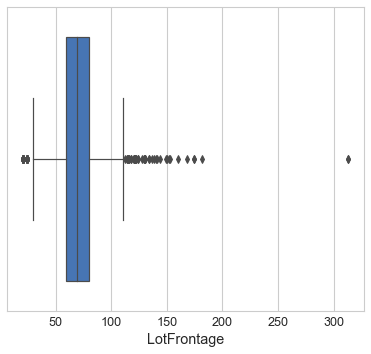

In [55]:
print('\x1b[1;0346m'+'Boxplot {}'.format('LotFrontage') +'\x1b[0m')
sns.boxplot(x=houses['LotFrontage'])

Distplot LotFrontage


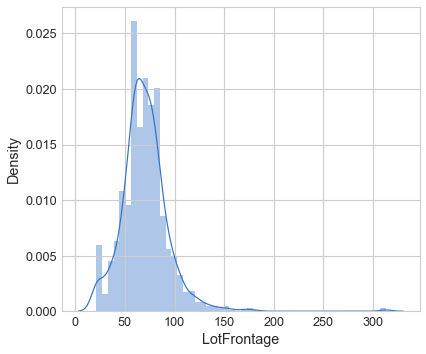

In [56]:
print('\x1b[1;0346m'+'Distplot {}'.format('LotFrontage')+'\x1b[0m')
sns.distplot(houses['LotFrontage'])
plt.show()

Выброс только один, но не он нас сейчас волнует. На гистограмме видно, что, в принципе, распределение похоже на нормальное. Да, есть ряд значений, представленный несколько чаще, чем при нормальном распределении, но, тем не менее, значения можно предсказать. В таком случае возьмем линейную регрессию для заполнения пропусков:

Выберем столбцы, с помощью которых будем предсказывать:

In [57]:
LotFrontage = houses[['LotShape', 'LotArea', 'Street', 'LotConfig', 'Neighborhood', 'LandSlope', 'LotFrontage']]
LotFrontage.head()

,LotShape,LotArea,Street,LotConfig,Neighborhood,LandSlope,LotFrontage
0,Reg,8450,Pave,Inside,CollgCr,Gtl,65.0
1,Reg,9600,Pave,FR2,Veenker,Gtl,80.0
2,IR1,11250,Pave,Inside,CollgCr,Gtl,68.0
3,IR1,9550,Pave,Corner,Crawfor,Gtl,60.0
4,IR1,14260,Pave,FR2,NoRidge,Gtl,84.0


In [58]:
LotFrontage_data = pd.get_dummies(LotFrontage.loc[ :, ['LotShape', 'Street', 'LotConfig', 'Neighborhood', 'LandSlope']], columns = ['LotShape', 'Street', 'LotConfig', 'Neighborhood', 'LandSlope'] )
LotFrontage_data['LotArea'] = houses['LotArea']
LotFrontage_data['LotFrontage'] = houses['LotFrontage']
LotFrontage_data.head()

,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Street_Grvl,Street_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotArea,LotFrontage
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,8450,65.0
1,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,9600,80.0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,11250,68.0
3,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,9550,60.0
4,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,14260,84.0


In [59]:
X_train = LotFrontage_data.dropna()
X_train = X_train.drop('LotFrontage', axis=1)
X_train.shape

(1201, 40)

In [60]:
X_test = LotFrontage_data[LotFrontage_data['LotFrontage'].isna()]
X_test = X_test.drop('LotFrontage', axis=1)
X_test.shape

(259, 40)

In [61]:
y_train = LotFrontage_data['LotFrontage'].dropna()
y_train.shape

(1201,)

In [62]:
y_test = LotFrontage_data.loc[LotFrontage_data[LotFrontage_data['LotFrontage'].isna()].index, 'LotFrontage']
y_test.shape

(259,)

In [64]:
linreg = LinearRegression().fit(X_train,y_train)
LotFrontage_data.loc[LotFrontage_data[LotFrontage_data['LotFrontage'].isna()].index, 'LotFrontage'] = linreg.predict(X_test).round()

In [65]:
LotFrontage_data['LotFrontage'][155:170]

155     60.0
156     60.0
157     92.0
158    100.0
159    134.0
160     40.0
161    110.0
162     95.0
163     55.0
164     40.0
165     62.0
166     78.0
167     86.0
168     62.0
169     91.0
Name: LotFrontage, dtype: float64

In [66]:
houses['LotFrontage'][155:170]

155     60.0
156     60.0
157     92.0
158    100.0
159    134.0
160      NaN
161    110.0
162     95.0
163     55.0
164     40.0
165     62.0
166      NaN
167     86.0
168     62.0
169      NaN
Name: LotFrontage, dtype: float64

In [67]:
houses['LotFrontage'] = LotFrontage_data['LotFrontage']

In [68]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Все пробелы заполнены.

Еще у нас есть один столбец, который не несет никакой смысловой информации - это "Id". На всякий случай выведем его:

In [69]:
houses['Id'].unique()

array([   1,    2,    3, ..., 1458, 1459, 1460], dtype=int64)

Да, действительно это столбец с порядковыми номерами. Для обучения он нам не пригодится. Удалим его:

In [70]:
houses = houses.drop('Id', axis=1)
houses.shape

(1460, 80)

Теперь посмотрим, какие признаки больше всего коррелируют с нашей целевой переменной:

In [71]:
houses.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
GarageYrBlt      0.261366
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.340774
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.472614
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

Итак, больше всего коррелируют с SalePrice столбцы OverallQual, GrLivArea, GarageCars, GarageArea и TotalBsmtSF. Запомним их, т.к. в дальнейшем попробуем обучить модели не на всех признаках, а только на тех, что лучше всего коррелируют с таргетом.   
Идем дальше.

***Подготовка признаков:***

Для того, чтобы обучить модели, необходимо подготовить признаки: перевести категориальные признаки в числовой формат (причем нужно будет воспользоваться техникой OHE, поскольку у нас будет использоваться как минимум одна линейная модель); отмасштабировать признаки. Этим и займемся:

Для начала разделим признаки на качественные и количественные. Первые нам слеует перевести техникой OHE, а вторые - нормализовать:

In [72]:
obj = []
num = []

for i in houses.columns:
    if houses[i].dtype == 'object':
        obj.append(i)
    else:
        num.append(i)

In [73]:
obj

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [74]:
num

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [75]:
len(obj) + len(num)

80

In [76]:
houses[obj]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,no,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,no,no,no,WD,Normal
1,RL,Pave,no,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,no,no,no,WD,Normal
2,RL,Pave,no,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,no,no,no,WD,Normal
3,RL,Pave,no,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,no,no,no,WD,Abnorml
4,RL,Pave,no,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,no,no,no,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,no,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,no,no,no,WD,Normal
1456,RL,Pave,no,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,no,MnPrv,no,WD,Normal
1457,RL,Pave,no,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,no,GdPrv,Shed,WD,Normal
1458,RL,Pave,no,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,no,no,no,WD,Normal


Теперь закодируем качественные признаки:

In [77]:
houses = pd.get_dummies(houses, drop_first=True)
houses.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


Теперь разделим выборку на трейн и тест, а далее - нормализуем признаки количественные:

In [78]:
features = houses.drop('SalePrice', axis=1)
target = houses['SalePrice']
features.shape, target.shape

((1460, 259), (1460,))

Поскольку в задании сказано, что для валидации модели 2-го уровня нужно использовать отдельный hold-out датасет, как на занятии, то разделим датасет не на 2, а на 3 части: тренировочную, валидационную и тестовую. Тестовую пока "спрячем", на тренировочной будем обучать модель, а при помощи валидационной выборки подберем оптимальные гиперпараметры:

In [79]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=42)

In [80]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

In [81]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((1022, 259), (219, 259), (219, 259), (1022,), (219,), (219,))

In [82]:
scaler = StandardScaler()
scaler.fit(features_train[num[:-1]])
features_train[num[:-1]] = scaler.transform(features_train[num[:-1]])
features_valid[num[:-1]] = scaler.transform(features_valid[num[:-1]])
features_test[num[:-1]] = scaler.transform(features_test[num[:-1]])
features_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1418,-0.868950,-0.015227,-0.136119,-0.823057,-0.508624,-0.260141,-1.049206,-0.608547,-0.916106,5.489282,...,0,0,0,0,0,0,0,0,1,0
44,-0.868950,-0.055334,-0.247297,-0.823057,0.392266,-0.390291,-1.242098,-0.608547,-0.581138,3.067631,...,0,0,0,0,1,0,0,0,1,0
588,-0.868950,-0.255870,1.267158,-0.823057,2.194045,-0.097453,0.879717,-0.608547,1.909367,-0.280335,...,0,0,0,0,1,0,0,0,0,1
1048,-0.868950,1.147882,0.971773,-0.823057,-1.409513,-0.357753,1.024387,-0.173672,-0.970484,-0.280335,...,0,0,0,0,1,0,0,0,1,0
439,-0.165531,-0.175655,0.142046,-0.093513,2.194045,-1.659253,0.735048,-0.608547,-0.970484,-0.280335,...,1,0,0,0,0,0,0,0,1,0


In [83]:
features_valid.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
365,0.303415,-0.496513,-0.004895,-0.823057,1.293156,-1.659253,0.590379,-0.608547,0.021368,-0.280335,...,0,0,0,0,1,0,0,0,1,0
1331,0.537888,-0.656941,0.003052,-0.823057,-0.508624,0.162847,-0.422306,-0.608547,0.080096,-0.280335,...,0,0,0,0,1,0,0,0,1,0
619,0.068942,0.546274,0.132333,1.365574,-0.508624,1.041359,0.879717,0.701876,0.924040,-0.280335,...,0,0,0,0,1,0,0,0,1,0
1058,0.068942,0.987453,0.049678,2.095118,-0.508624,1.204047,1.120833,0.284396,1.065423,-0.280335,...,0,0,0,0,1,0,0,0,1,0
81,1.475780,-1.579407,-0.551512,-0.093513,-0.508624,0.878672,0.638602,1.960114,1.641828,-0.280335,...,0,0,0,0,1,0,0,0,1,0


Признаки готовы, можно обучать:

## Шаг 2. Обучение модели случайного леса

R2 Score for RandomForestRegressor:  0.863211343566004


Text(0.5, 1.0, 'Feature importance using RandomForestRegressor Model')

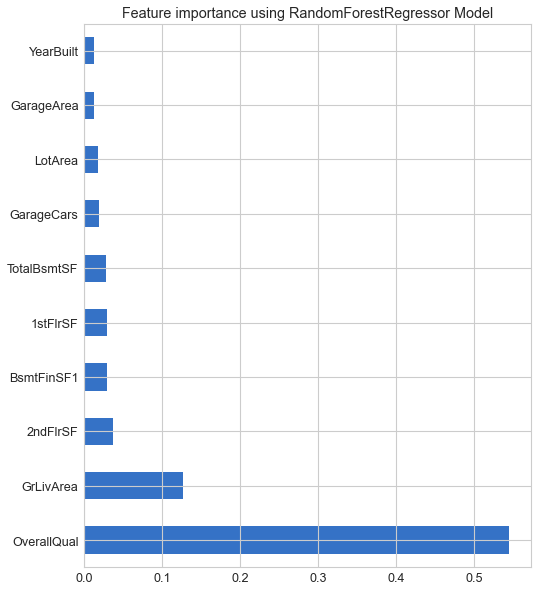

In [84]:
rfr = RandomForestRegressor().fit(features_train, target_train)
r_2 = cross_val_score(rfr, features_valid, target_valid, scoring='r2', cv=10)
print('R2 Score for RandomForestRegressor: ', r_2.mean())

rfr_coef = pd.Series(rfr.feature_importances_, index = features_train.columns)
rfr_imp_coef = rfr_coef.sort_values(ascending=False)
rfr_imp_coef = rfr_imp_coef[:10]

plt.rcParams['figure.figsize'] = (8.0, 10.0)
rfr_imp_coef.plot(kind = "barh")
plt.title("Feature importance using RandomForestRegressor Model")

Подводим итог: наиболее важный признак - внешний вид дома (отделка и материалы). На втором месте - общая площадь надземных жилых помещений в квадратных футах.  
Вспомним теперь, какие признаки лучше всего коррелируют с таргетом:

In [85]:
houses.corr()['SalePrice'].sort_values(ascending=False)[:20]

SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
Foundation_PConc         0.497734
MasVnrArea               0.472614
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtFinType1_GLQ         0.434597
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
SaleType_New             0.357509
SaleCondition_Partial    0.352060
Name: SalePrice, dtype: float64

Как оказалось, практически все признаки, оказавшиеся важными для обучения модели, неплохо коррелируют с таргетом.  
При этом отметим, что мы не использовали никакие гиперпараметры, а просто обучили модель. Можно попробовать перебрать гиперпараметры и определить, какие признаки будут наиболее значимыми в таком случае:

In [86]:
param_rfr = {'max_depth': np.arange(2, 11, 2), 
             'n_estimators': np.arange(80, 151, 30),
            'min_samples_split': np.arange(2, 13, 2)}

In [87]:
%%time
scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid = GridSearchCV(rfr, param_rfr, scoring=scorer, cv=10)
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 10, 'min_samples_split': 8, 'n_estimators': 80}
Wall time: 11min 11s


Поиграв еще немного, нашли оптимальный вариант:

R2 Score for RandomForestRegressor:  0.8693184720945613


Text(0.5, 1.0, 'Feature importance using RandomForestRegressor Model')

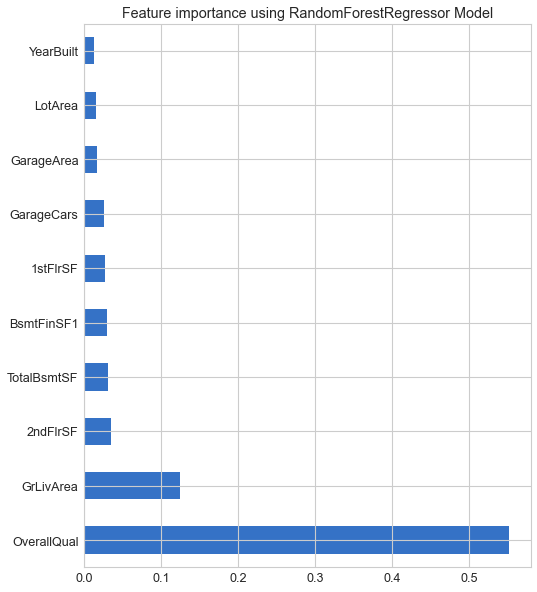

In [89]:
rfr = RandomForestRegressor(max_depth=10, min_samples_split=8, n_estimators=150, random_state=12345).fit(features_train, target_train)
r_2 = cross_val_score(rfr, features_valid, target_valid, scoring='r2', cv=10)
print('R2 Score for RandomForestRegressor: ', r_2.mean())

rfr_coef = pd.Series(rfr.feature_importances_, index = features_train.columns)
rfr_imp_coef = rfr_coef.sort_values(ascending=False)
rfr_imp_coef = rfr_imp_coef[:10]

plt.rcParams['figure.figsize'] = (8.0, 10.0)
rfr_imp_coef.plot(kind = "barh")
plt.title("Feature importance using RandomForestRegressor Model")

И R2 на валидации:

In [146]:
valid_pred_rfr = rfr.predict(features_valid)
r_2_rfr_valid = r2_score(target_valid, valid_pred_rfr, multioutput='variance_weighted')
print('R2 for RandomForestRegressor: ', r_2_rfr_valid)

R2 for RandomForestRegressor:  0.9026673011996743


Коэффициент R2 подрос, гиперпараметры своё отработали. Тройка наиболее значимых признаков не поменялась. А вот чуть менее значимые признаки изменились.  
Поскольку лучшие признаки схожи с тем, что показал анализ корреляции признаков, оставим только те признаки, что хорошо себя зарекомендовали: т.е. 20 лучших:

In [90]:
rfr_imp_coef = rfr_coef.sort_values(ascending=False)[:20]
rfr_imp_coef

OverallQual     0.552453
GrLivArea       0.124256
2ndFlrSF        0.034848
TotalBsmtSF     0.031367
BsmtFinSF1      0.029735
1stFlrSF        0.026905
GarageCars      0.025278
GarageArea      0.017193
LotArea         0.015293
YearBuilt       0.012989
YearRemodAdd    0.008072
LotFrontage     0.007649
WoodDeckSF      0.006507
GarageYrBlt     0.006324
BsmtQual_Gd     0.006296
OpenPorchSF     0.005898
ScreenPorch     0.005576
TotRmsAbvGrd    0.004493
BsmtUnfSF       0.004472
OverallCond     0.004210
dtype: float64

In [91]:
features_train_1 = features_train[[col for col in rfr_imp_coef.index.tolist()]]
features_train_1

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,YearBuilt,YearRemodAdd,LotFrontage,WoodDeckSF,GarageYrBlt,BsmtQual_Gd,OpenPorchSF,ScreenPorch,TotRmsAbvGrd,BsmtUnfSF,OverallCond
135,0.636031,0.287835,-0.802294,0.546130,-0.970484,1.315652,0.296063,0.253813,-0.030504,-0.032378,-0.711644,0.345738,0.003427,0.216266,0,-0.715974,-0.275896,0.279234,1.643785,0.392266
1452,-0.823057,-0.861565,-0.802294,-1.146608,0.219303,-0.251022,0.296063,0.229814,-0.624365,1.106434,0.976164,-1.459085,-0.741099,0.295218,1,-0.311187,-0.275896,-0.948194,-1.281383,-0.508624
762,0.636031,0.033459,0.973582,-0.679260,-0.918281,-1.042064,0.296063,0.656997,-0.185924,1.236584,1.169056,0.024881,0.542828,0.304241,1,-0.065423,-0.275896,0.279234,0.360659,-0.508624
932,2.095118,0.708025,-0.802294,1.890034,-0.970484,1.888387,1.665189,1.492165,0.081645,1.138972,1.024387,0.506167,-0.741099,0.297474,0,2.045255,-0.275896,0.892948,2.991965,-0.508624
435,0.636031,0.248265,1.089252,-0.583107,-0.133065,-0.880260,0.296063,0.349809,-0.006927,0.813597,0.542156,-1.138228,0.459259,0.274916,1,0.165884,-0.275896,-0.334480,-1.124357,0.392266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.093513,-0.405573,-0.802294,0.568491,-0.918281,0.370511,0.296063,-0.178171,-0.126140,1.138972,1.024387,0.265524,-0.741099,0.297474,1,-0.397927,-0.275896,-0.334480,1.612380,-0.508624
1130,-1.552600,0.851229,0.678737,0.139158,0.382437,0.406468,0.296063,0.474604,-0.259748,-1.398953,-1.676106,-0.255870,2.533295,0.241079,0,-0.079880,-0.275896,0.279234,-0.159770,-2.310403
1294,-0.823057,-1.253491,-0.802294,-0.437760,-0.607240,-0.785232,0.296063,0.455405,-0.227251,-0.520441,0.252817,-0.456406,-0.741099,0.186941,0,-0.715974,-0.275896,-0.948194,0.282146,1.293156
860,0.636031,-0.194536,0.363479,-0.330426,-0.970484,-0.661953,-1.073062,-1.253330,-0.274053,-1.724328,0.638602,-0.656941,-0.741099,0.114756,0,2.753633,-0.275896,0.279234,0.764440,2.194045


In [92]:
features_valid_1 = features_valid[[col for col in rfr_imp_coef.index.tolist()]]
features_valid_1

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,YearBuilt,YearRemodAdd,LotFrontage,WoodDeckSF,GarageYrBlt,BsmtQual_Gd,OpenPorchSF,ScreenPorch,TotRmsAbvGrd,BsmtUnfSF,OverallCond
365,-0.823057,-0.349046,0.721830,-0.867093,0.021368,-1.278349,-1.073062,-0.043776,-0.004895,-1.659253,0.590379,-0.496513,-0.741099,0.202731,0,1.134483,-0.275896,-0.334480,-0.796846,1.293156
1331,-0.823057,-1.083907,-0.802294,-0.332662,0.080096,-0.554083,0.296063,0.474604,0.003052,0.162847,-0.422306,-0.656941,-0.741099,0.229800,0,-0.715974,-0.275896,-0.334480,-0.321282,-0.508624
619,1.365574,1.380706,0.966778,0.944158,0.924040,0.801989,1.665189,1.304972,0.132333,1.041359,0.879717,0.546274,0.535231,0.290706,1,-0.715974,-0.275896,2.120377,0.089229,-0.508624
1058,2.095118,1.233734,1.588221,0.098908,1.065423,-0.102059,1.665189,1.722557,0.049678,1.204047,1.120833,0.987453,-0.741099,0.301985,0,0.758609,-0.275896,2.120377,-0.904521,-0.508624
81,-0.093513,-0.362235,-0.802294,0.396311,1.641828,0.429583,0.296063,-0.346164,-0.551512,0.878672,0.638602,-1.579407,-0.741099,0.279428,0,2.160908,-0.275896,-0.948194,-1.200627,-0.508624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,-0.093513,-0.948241,-0.802294,-0.075509,-0.015609,-0.369164,0.296063,-0.178171,-0.248621,-0.064916,0.976164,-0.416298,0.558023,0.214010,0,-0.022053,-0.275896,-0.948194,-1.023412,2.194045
1243,2.824662,1.030234,-0.802294,2.272410,2.044224,2.327570,1.665189,1.789754,0.277773,1.138972,1.024387,1.428632,0.899897,0.297474,0,2.594609,-0.275896,0.279234,0.266444,-0.508624
859,-0.093513,2.119337,1.787809,-0.012898,0.375912,0.879038,0.296063,0.680996,0.025040,-0.097453,-0.036521,1.067667,-0.741099,0.211754,0,0.223711,3.659009,1.506662,-0.305579,1.293156
650,0.636031,0.255802,1.109665,-0.551801,-0.970484,-0.893101,0.296063,0.407407,-0.231401,1.171509,1.072610,-0.255870,-0.741099,0.299730,1,-0.715974,-0.275896,0.279234,0.542361,0.392266


In [93]:
features_test_1 = features_test[[col for col in rfr_imp_coef.index.tolist()]]
features_test_1

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,YearBuilt,YearRemodAdd,LotFrontage,WoodDeckSF,GarageYrBlt,BsmtQual_Gd,OpenPorchSF,ScreenPorch,TotRmsAbvGrd,BsmtUnfSF,OverallCond
1418,-0.823057,-0.725898,-0.802294,0.188352,-0.916106,-0.066103,-1.073062,-0.677352,-0.136119,-0.260141,-1.049206,-0.015227,-0.741099,0.198220,0,0.556215,-0.275896,-0.334480,-0.727306,-0.508624
44,-0.823057,-0.714592,-0.802294,0.201769,-0.581138,-0.050693,-1.073062,-0.850145,-0.247297,-0.390291,-1.242098,-0.055334,-0.741099,0.191452,0,-0.715974,-0.275896,-0.334480,-0.238283,0.392266
588,-0.823057,-0.105976,-0.802294,0.843533,1.909367,0.778874,-1.073062,-0.120573,1.267158,-0.097453,0.879717,-0.255870,-0.741099,0.211754,0,-0.022053,0.787592,-0.948194,-1.027899,2.194045
1048,-0.823057,0.455534,-0.802294,-2.369762,-0.970484,1.544233,0.296063,-0.677352,0.971773,-0.357753,1.024387,1.147882,-0.741099,0.193708,0,-0.715974,-0.275896,1.506662,-1.281383,-1.409513
439,-0.093513,-0.627916,0.358943,-0.840260,-0.970484,-1.247529,0.296063,0.244213,0.142046,-1.659253,0.735048,-0.175655,-0.741099,0.295218,0,-0.050966,-0.275896,0.279234,0.252984,2.194045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,-0.823057,-1.117824,-0.802294,-0.276760,-0.431056,-0.600313,-1.073062,-0.811747,-0.430709,-0.487903,0.735048,0.105095,-0.741099,0.184685,0,-0.715974,2.560072,-1.561909,-0.276417,1.293156
374,0.636031,0.751363,1.649458,-0.475774,-0.970484,-0.828893,0.296063,-0.206970,-0.224778,1.041359,0.927940,-0.255870,0.018621,0.290706,1,-0.022053,-0.275896,0.892948,0.618630,-0.508624
411,-0.823057,-0.891713,-0.802294,-0.008426,1.326436,-0.292115,0.296063,0.455405,2.110926,-0.520441,-1.434991,1.147882,1.264562,0.182429,0,-0.715974,-0.275896,-0.948194,-1.281383,-0.508624
1134,-0.093513,0.133325,0.749046,-0.321482,-0.970484,-0.651679,0.296063,-0.082175,-0.174179,0.846134,0.590379,-0.576727,0.018621,0.277172,1,-0.166620,-0.275896,0.279234,0.773413,-0.508624


Теперь еще раз обучим лес, при этом проверим качество при помощи кросс-валидации, разделив выборку на 10 фолдов:

In [96]:
rfr_1 = RandomForestRegressor(max_depth=10, min_samples_split=8, n_estimators=150, random_state=12345).fit(features_train_1, target_train)

In [97]:
r_2 = cross_val_score(rfr_1, features_valid, target_valid, scoring='r2', cv=10)
print('R2 Score for RandomForestRegressor: ', r_2.mean())

R2 Score for RandomForestRegressor:  0.8693184720945613


In [149]:
valid_pred_rfr_1 = rfr_1.predict(features_valid_1)
r_2_rfr_valid_1 = r2_score(target_valid, valid_pred_rfr_1, multioutput='variance_weighted')
print('R2 for RandomForestRegressor: ', r_2_rfr_valid_1)

R2 for RandomForestRegressor:  0.8980992761080189


Получается, в данном случае мы не все значимые признаки отобрали. Поэтому оставим количество фичей как было изначально.

## Шаг 3. Обучение стекинга из нескольких моделей

In [119]:
regressor = StackingRegressor(
    [   ('lr', Ridge()),                                                       # l2
        ('svr', SVR(kernel='linear')),                                         # метод опорных векторов в регрессии
        ('dtr', DecisionTreeRegressor(random_state=42)),                       # дерево
        ('rfr', RandomForestRegressor(max_depth=10, 
                                      min_samples_split=8, 
                                      n_estimators=150, 
                                      random_state=12345))], LinearRegression())  # лес (возьмем с уже подобранными параметрами)

In [133]:
regressor.fit(features_train, target_train)

StackingRegressor(estimators=[('lr', Ridge()), ('svr', SVR(kernel='linear')),
                              ('dtr', DecisionTreeRegressor(random_state=42)),
                              ('rfr',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=8,
                                                     n_estimators=150,
                                                     random_state=12345))],
                  final_estimator=LinearRegression())

Сравним показатели:

In [134]:
r_2_lr = cross_val_score(regressor.named_estimators_['lr'], features_valid, target_valid, scoring='r2', cv=10).mean()
print('R2 Score for Ridge: ', r_2_lr)

r_2_svr = cross_val_score(regressor.named_estimators_['svr'], features_valid, target_valid, scoring='r2', cv=10).mean()
print('R2 Score for SVR: ', r_2_svr)

r_2_dtr = cross_val_score(regressor.named_estimators_['dtr'], features_valid, target_valid, scoring='r2', cv=10).mean()
print('R2 for DecisionTreeRegressor: ', r_2_dtr)

r_2_rfr = cross_val_score(regressor.named_estimators_['rfr'], features_valid, target_valid, scoring='r2', cv=10).mean()  
print('R2 for RandomForestRegressor: ', r_2_rfr)

r_2_regression = cross_val_score(regressor, features_valid, target_valid, scoring='r2', cv=10).mean()  
print('R2 for StackingRegressor: ', r_2_regression)

result = pd.DataFrame()

result['Model'] = ['Ridge', 'SVR', 'DecisionTreeRegressor', 'RandomForestRegressor', 'StackingRegressor']
result['R2'] = [r_2_lr, r_2_svr, r_2_dtr, r_2_rfr, r_2_regression]

R2 Score for Ridge:  0.8670898098795478
R2 Score for SVR:  -0.06641676879226821
R2 for DecisionTreeRegressor:  0.6935490998628919
R2 for RandomForestRegressor:  0.8693184720945613
R2 for StackingRegressor:  0.8972709402701522


Построим гистограмму и посмотрим, показатель какой модели лучше:

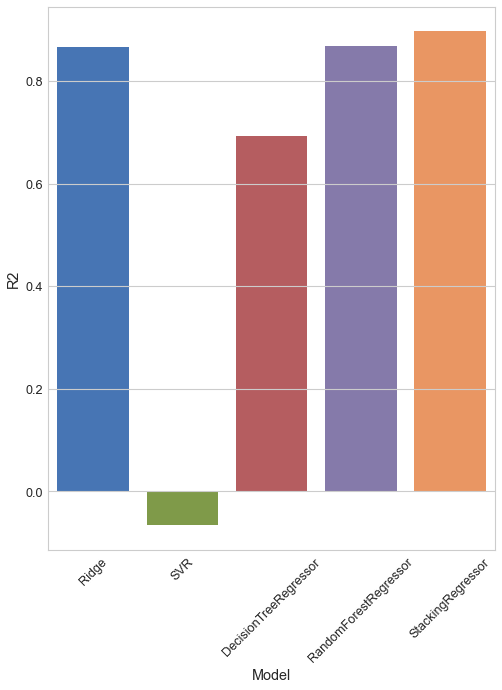

In [135]:
sns.barplot(x='Model', y='R2', data=result)
plt.tick_params(axis='x', rotation=45)

Модель SVR показала отрицательный результат. Уберем его и результат дерева решений и посмотрим снова:

In [136]:
result = result[(result['Model'] != 'SVR') & (result['Model'] != 'DecisionTreeRegressor')]
result

,Model,R2
0,Ridge,0.867090
3,RandomForestRegressor,0.869318
4,StackingRegressor,0.897271


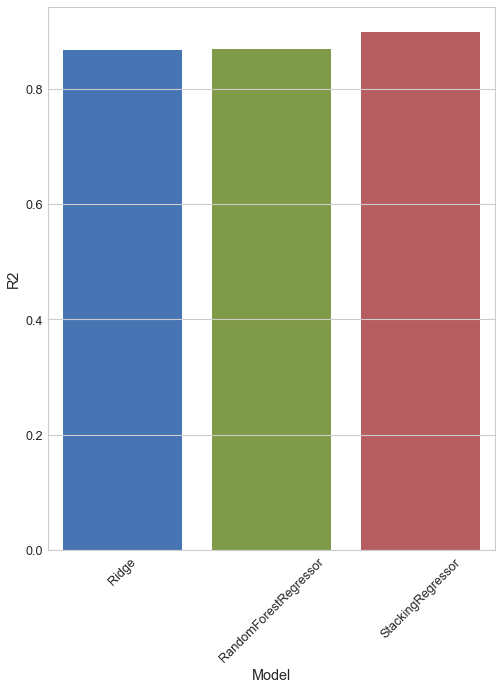

In [137]:
sns.barplot(x='Model', y='R2', data=result)
plt.tick_params(axis='x', rotation=45)

Теперь видно, что ансамблевая модель показала лучший результат.

Итак, получается, стекинг моделей "вытянули" случайный лес и линейная модель с регуляризацией l2.

И R2 на валидации:

In [153]:
valid_pred_regr = regressor.predict(features_valid)
r_2_regression_valid = r2_score(target_valid, valid_pred_regr, multioutput='variance_weighted')
print('R2 for StackingRegressor: ', r_2_regression_valid)

R2 for StackingRegressor:  0.9170370562519115


## Шаг 4. Проверка работы модели на тестовой выборке:

Модель случайного леса:

In [152]:
pred_rfr = rfr.predict(features_test)
r_2_rfr_test = r2_score(target_test, pred_rfr, multioutput='variance_weighted')
print('R2 for RandomForestRegressor: ', r_2_rfr_test)

R2 for RandomForestRegressor:  0.88403913159743


Стекинг моделей:

In [151]:
pred_regr = regressor.predict(features_test)
r_2_regression_test = r2_score(target_test, pred_regr, multioutput='variance_weighted')
print('R2 for StackingRegressor: ', r_2_regression_test)

R2 for StackingRegressor:  0.8950503509445106


Теперь очень хорошо видно, что стекинг моделей справился с заданием лучше, чем ансамблевая модель "случайный лес".  
При этом отметим, что ни модель случайного леса, ни стекинг не переобучились.

## Выводы

Таким образом, в данной работе реализованы следующие задачи:  
    - осуществлена предобработка данных: все пропуски заменены подходящими значениями, данные имеют нужный тип, отмасштабированы и перекодированы.  
    - выборка разделена на 3 части, чтобы осуществить проверку работы моделей на отдельном hold-out датасете.  
    - построена модель случайного леса, подобраны гиперпараметры, выведены наиболее важные признаки. Качество модели проверено с помощью cross_val_score.    
    - обучен стекинг 4 моделей; использованы 2 линейные и 2 нелинейные модели.     
    
В итоге эксперимента оказалось, что стекинговая модель лучше справилась с задачей предсказания стоимости недвижимости. Это видно и на валидации, и на тесте. При этом наиболее значимым стало предсказание модели случайного леса в стекинге.